In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import nltk
#nltk.download()

train_df = pd.read_csv('train.csv')
#train_df.head()
print(train_df)

            id                        url  \
0            0                    m.kp.md   
1            1                  www.kp.by   
2            2              fanserials.tv   
3            3            colorbox.spb.ru   
4            4              tula-sport.ru   
...        ...                        ...   
135304  135304                    mail.ru   
135305  135305                 www.ntv.ru   
135306  135306  topclassiccarsforsale.com   
135307  135307                wowcream.ru   
135308  135308                 www.ubu.ru   

                                                    title  target  
0       Экс-министр экономики Молдовы - главе МИДЭИ, ц...   False  
1       Эта песня стала известна многим телезрителям б...   False  
2       Банши 4 сезон 2 серия Бремя красоты смотреть о...   False  
3                                   Не Беси Меня Картинки   False  
4       В Новомосковске сыграют следж-хоккеисты алекси...   False  
...                                                

In [2]:
test_df = pd.read_csv("test.csv")
test_df

,id,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67
...,...,...,...
165373,300682,etp.armtek.ru,Armtek - запчасти для грузовых и легковых авто...
165374,300683,mail.ru,"Лилия Якупова - Караганда, Карагандинская обла..."
165375,300684,xn----8sbnqchpeeeth.xn--p1ai,Администрация Лесного района Тверской области ...
165376,300685,www-sunhome-ru.cdn.ampproject.org,Сонник Изменение сознания. К чему снится Измен...


In [3]:
train_df['target'].value_counts()

False    118594
True      16715
Name: target, dtype: int64

In [4]:
# Поглядим, какие есть уникальные url
unique_urls = train_df['url'].value_counts()
print(unique_urls)

mail.ru                  7900
baza.drom.ru             1042
www.olx.ua                945
irecommend.ru             767
daftsex.com               741
                         ... 
www.lotsman.su              1
potolok51.ru                1
almaty.vsepoezda.com        1
www.gorodskievesti.ru       1
worldpoolsochi.ru           1
Name: url, Length: 40391, dtype: int64


In [5]:
# Для каждого рассчитываем процент положительных и отрицательных

# freq_urls = unique_urls[unique_urls > 10]
# freq_urls = unique_urls
# urls = []
# pos_ratios = []
# neg_ratios = []
# nums = []
# for url_i in freq_urls.index:
#     idxs = train_df['url'] == url_i
#     targets = train_df[idxs]['target']
#     n_true = targets[targets == 1].size
#     urls.append(url_i)
#     pos_ratios.append(n_true/targets.size)
#     neg_ratios.append(1 - n_true/targets.size)
#     nums.append(targets.size)

# url_info_df = pd.DataFrame({'url' : urls, 'pos_ratio' : pos_ratios, 'neg_ratio' : neg_ratios, 'num' : nums})
url_info_df = pd.read_csv('url_info.csv')

# А теперь вводим метрики, учитывающие количество появлений url
# Для этого будем умножать на сигмоиды
pos_sigm = url_info_df['pos_ratio'] * 1/(1 + 12*np.exp(-(url_info_df['num'] - 2.5)))
neg_sigm = url_info_df['neg_ratio'] * 1/(1 + 12*np.exp(-(url_info_df['num'] - 2.5)))
url_info_df['pos_sigm'] = pos_sigm
url_info_df['neg_sigm'] = neg_sigm
url_info_df.to_csv('url_info.csv', index=False)

print(url_info_df)

                             url  pos_ratio  neg_ratio   num  pos_sigm  \
0                        mail.ru   0.016203   0.983797  7900  0.016203   
1                   baza.drom.ru   0.000000   1.000000  1042  0.000000   
2                     www.olx.ua   0.000000   1.000000   945  0.000000   
3                  irecommend.ru   0.000000   1.000000   767  0.000000   
4                    daftsex.com   1.000000   0.000000   741  1.000000   
...                          ...        ...        ...   ...       ...   
40386  dalnerechensk.bankiros.ru   0.000000   1.000000     1  0.000000   
40387               whatname.net   0.000000   1.000000     1  0.000000   
40388            makulatura57.ru   0.000000   1.000000     1  0.000000   
40389      www.chirana-russia.ru   0.000000   1.000000     1  0.000000   
40390               kam.kam24.ru   0.000000   1.000000     1  0.000000   

       neg_sigm  
0      0.983797  
1      1.000000  
2      1.000000  
3      1.000000  
4      0.000000  
...

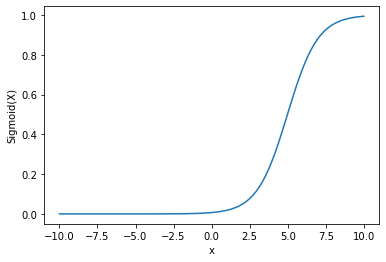

0.0353368440280961


In [6]:
# Если что, вот эта сигмоида
x = np.linspace(-10, 10, 100)
coef = 0.5
sigm = 1/(1 + 12*np.exp(-(x-2.5)))
plt.plot(x, sigm) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)")
  
plt.show()
print(1/(1 + coef*np.exp(4)))

In [7]:
# Добавляем эти сигмоидные метрики в датафреймы
train_df_m = pd.merge(train_df, url_info_df, how='left',on=['url'])
test_df_m = pd.merge(test_df, url_info_df, how='left',on=['url'])
# Если такого url в test не было в train -- просто обнуляем
test_df_m = test_df_m.fillna(value=0.)
test_df_m.head()


,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...,0.0,1.0,10.0,0.000000,0.993407
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ...",0.0,1.0,6.0,0.000000,0.734016
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ...",1.0,0.0,1.0,0.018255,0.000000
4,135313,2gis.ru,67,0.0,1.0,75.0,0.000000,1.000000


In [8]:
# Теперь непосредственно обрабатываем тайтлы
# Всё в нижни регистр
train_df_m['title'] = train_df_m['title'].str.lower()
test_df_m['title'] = test_df_m['title'].str.lower()
test_df_m.head()

,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,шестой кассационный суд в самаре начнет работу...,0.0,1.0,10.0,0.000000,0.993407
1,135310,urexpert.online,"что такое индексация алиментов, кем и в каких ...",0.0,1.0,6.0,0.000000,0.734016
2,135311,imperimeha.ru,женщинам | империя меха - part 12,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,"небритые, волосатые киски: порно всех стран и ...",1.0,0.0,1.0,0.018255,0.000000
4,135313,2gis.ru,67,0.0,1.0,75.0,0.000000,1.000000


In [9]:
# Удаляем всё, что не буквы
train_df_m['title'] = train_df_m['title'].str.replace('[^a-zA-Zа-яА-Я ]', ' ')
test_df_m['title'] = test_df_m['title'].str.replace('[^a-zA-Zа-яА-Я ]', ' ')
test_df_m.head()

,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,шестой кассационный суд в самаре начнет работу...,0.0,1.0,10.0,0.000000,0.993407
1,135310,urexpert.online,что такое индексация алиментов кем и в каких ...,0.0,1.0,6.0,0.000000,0.734016
2,135311,imperimeha.ru,женщинам империя меха part,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,небритые волосатые киски порно всех стран и ...,1.0,0.0,1.0,0.018255,0.000000
4,135313,2gis.ru,,0.0,1.0,75.0,0.000000,1.000000


In [10]:
import pymorphy2

# Лемматизируем
lemmatizer = pymorphy2.MorphAnalyzer()

lemmatizer_cache = {}
def lem_text(text):
    return ' '.join([lem_token(token) for token in text.split()])

def lem_token(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

train_df_m['title'] = train_df_m['title'].apply(lem_text)
test_df_m['title'] = test_df_m['title'].apply(lem_text)
test_df_m.head()

,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,шестой кассационный суд в самара начать работа...,0.0,1.0,10.0,0.000000,0.993407
1,135310,urexpert.online,что такой индексация алименты кто и в какой сл...,0.0,1.0,6.0,0.000000,0.734016
2,135311,imperimeha.ru,женщина империя мех part,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,небритый волосатый киска порно весь страна и н...,1.0,0.0,1.0,0.018255,0.000000
4,135313,2gis.ru,,0.0,1.0,75.0,0.000000,1.000000


In [11]:
# Убираем стоп-слова
from nltk.corpus import stopwords

mystopwords = stopwords.words('russian') + stopwords.words('english')

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""

train_df_m['title'] = train_df_m['title'].apply(remove_stopwords)
test_df_m['title'] = test_df_m['title'].apply(remove_stopwords)
#train_df_m.head()
test_df_m.head()

,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www.kommersant.ru,шестой кассационный суд самара начать работа р...,0.0,1.0,10.0,0.000000,0.993407
1,135310,urexpert.online,индексация алименты случай производиться каков...,0.0,1.0,6.0,0.000000,0.734016
2,135311,imperimeha.ru,женщина империя мех part,0.0,0.0,0.0,0.000000,0.000000
3,135312,national-porn.com,небритый волосатый киска порно весь страна нац...,1.0,0.0,1.0,0.018255,0.000000
4,135313,2gis.ru,,0.0,1.0,75.0,0.000000,1.000000


In [12]:
# Сделаем tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
# Обучаемся и по валидационной выборке
tfidf_vectorizer.fit(pd.concat([train_df_m['title'], test_df_m['title']]))
train_titles_tfidf = tfidf_vectorizer.transform(train_df_m['title'])
test_titles_tfidf = tfidf_vectorizer.transform(test_df_m['title'])
print(train_titles_tfidf.shape)
print(test_titles_tfidf.shape)

(135309, 193847)
(165378, 193847)


In [13]:
# Попробуем спилить из url всё, что не буквы
train_df_m['url'] = train_df_m['url'].str.replace('[^a-zA-Zа-яА-Я ]', ' ')
test_df_m['url'] = test_df_m['url'].str.replace('[^a-zA-Zа-яА-Я ]', ' ')
test_df_m.head()

,id,url,title,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
0,135309,www kommersant ru,шестой кассационный суд самара начать работа р...,0.0,1.0,10.0,0.000000,0.993407
1,135310,urexpert online,индексация алименты случай производиться каков...,0.0,1.0,6.0,0.000000,0.734016
2,135311,imperimeha ru,женщина империя мех part,0.0,0.0,0.0,0.000000,0.000000
3,135312,national porn com,небритый волосатый киска порно весь страна нац...,1.0,0.0,1.0,0.018255,0.000000
4,135313,gis ru,,0.0,1.0,75.0,0.000000,1.000000


In [14]:
# tf-idf на url

tfidf_vectorizer = TfidfVectorizer()

#from sklearn.feature_extraction.text import CountVectorizer
#count_vectorizer = CountVectorizer()

# Обучаемся и по валидационной выборке
tfidf_vectorizer.fit(pd.concat([train_df_m['url'], test_df_m['url']]))

train_urls_tfidf = tfidf_vectorizer.transform(train_df_m['url'])
test_urls_tfidf = tfidf_vectorizer.transform(test_df_m['url'])

print(train_urls_tfidf.shape)
print(test_urls_tfidf.shape)

(135309, 54417)
(165378, 54417)


In [15]:
# Выравниваем выборку
def balance_data_idxs(data):
    true_idxs = np.arange(data.shape[0]) [data['target'] == True]
    false_idxs = np.arange(data.shape[0]) [data['target'] == False]
    random_false_idxs = np.random.choice(false_idxs, true_idxs.size, replace=False)
    temp = np.concatenate([true_idxs, random_false_idxs])
    random_idxs = np.random.choice(temp, temp.size, replace=False)
    return random_idxs

balance_idxs = balance_data_idxs(train_df_m)
print(balance_idxs)

[96260 25525 41430 ...  3295 18124 28192]


In [16]:
# Слепим данные

X_full_balanced = hstack([train_df_m.iloc[balance_idxs,7:], train_titles_tfidf[balance_idxs], train_urls_tfidf[balance_idxs]]).tocsr()
y_full_balanced = train_df_m['target'][balance_idxs]

X_train, X_test, y_train, y_test = train_test_split(X_full_balanced, y_full_balanced, test_size=0.2, random_state=42)
#X_train = X_train[balance_idxs]
#y_train = y_train.astype(int).values
#y_test = y_test.astype(int).values
print(X_full_balanced.shape)
print(y_full_balanced.shape)

(33430, 248266)
(33430,)


# Логистическая регрессия

In [17]:
# Вот и чего б не обучить регрессию?
# scores = []
# for i in range(10, 100, 10):
#     #print(i)    
#     log_clf = LogisticRegression(random_state=42, max_iter=i).fit(X_train, y_train)
#     y_pred = log_clf.predict(X_test)
#     y_pred_train = log_clf.predict(X_train)
#     scores.append([i, f1_score(y_test, y_pred)])
#print(scores)


log_clf = LogisticRegression(random_state=42, max_iter=100).fit(X_train, y_train)

y_pred_1 = log_clf.predict(X_test)
y_pred_train_1 = log_clf.predict(X_train)
print('log balanced train', f1_score(y_train, y_pred_train_1))
print('log balanced test ', f1_score(y_test, y_pred_1))

# Скор на всей выборке
X_full = hstack([train_df_m.iloc[:,7:], train_titles_tfidf, train_urls_tfidf]).tocsr()
y_full = train_df_m['target']
y_full_pred_1 = log_clf.predict(X_full)
print('log full: ', f1_score(y_full, y_full_pred_1))

log balanced train 0.9917442209546682
log balanced test  0.9832419256550883
log full:  0.9750615307060462


In [18]:
# Какие из всей выборки неправильно на регрессии?
# Видно, что чаще оно ложно срабатывает, чем ложно не срабатывает

y_wrong_1 = np.arange(y_full.size)[y_full_pred_1 != y_full]
#y_wrong_1 = balance_idxs[y_wrong_1]

#print(y_wrong_1)

print(train_df_m.iloc[y_wrong_1]['target'].value_counts())
print(np.unique(y_full_pred_1[y_wrong_1], return_counts=True))
train_df_m.iloc[y_wrong_1]

False    567
True     274
Name: target, dtype: int64
(array([False,  True]), array([274, 567]))


,id,url,title,target,pos_ratio,neg_ratio,num,pos_sigm,neg_sigm
76,76,eu ru net,воровайки мурки воровайки клип смотреть онлайн,False,0.000000,1.000000,1,0.000000,0.018255
775,775,mail ru,екатерина коб голый тыс результат поиск mail ru,True,0.016203,0.983797,7900,0.016203,0.983797
926,926,privat zapisi biz,,False,0.750000,0.250000,8,0.714939,0.238313
1027,1027,filmpornobesplatno com,,True,1.000000,0.000000,1,0.018255,0.000000
1042,1042,iehb info,download free kelly capone gets vibrator deep ...,False,0.000000,1.000000,1,0.000000,0.018255
...,...,...,...,...,...,...,...,...,...
134684,134684,converterino online,download abusada song mp mp free mp,False,0.284211,0.715789,95,0.284211,0.715789
134764,134764,tatcavideo ru,bigo live kиo nh sexy dance n sуi vs mиo xem v...,True,0.125000,0.875000,8,0.119156,0.834095
134846,134846,koketochka net,знакомство девушка рава русский,False,0.000000,1.000000,1,0.000000,0.018255
135184,135184,mail ru,фото группа фото сообщество сумасшедший муж же...,True,0.016203,0.983797,7900,0.016203,0.983797


# Лес

In [19]:
# А теперь лесок
rf_clf = RandomForestClassifier(random_state=42, n_estimators=10, n_jobs = 2).fit(X_train, y_train)
y_pred_2 = rf_clf.predict(X_test)
print('rf balanced test: ', f1_score(y_test, y_pred_2))

# Скор на всей выборке
y_full_pred_2 = rf_clf.predict(X_full)
print('rf-log full: ', f1_score(y_full, y_full_pred_2))

rf balanced test:  0.9923111714156491
rf-log full:  0.985027022237973


In [20]:
# Какие из всей выборки неправильно на лесе?

y_wrong_2 = np.arange(y_full.size)[y_full_pred_2 != y_full]
#y_wrong_1 = balance_idxs[y_wrong_1]

#print(y_wrong_1)
#train_df_m.iloc[y_wrong_3]

# Лес с добавленными предсказаниями регрессии

In [21]:
# А теперь лесок с добавленными туда предсказаниями регрессии
train_log_prob = log_clf.predict_proba(X_train)[:,1]
test_log_prob = log_clf.predict_proba(X_test)[:,1]
X_train_log = hstack([X_train, np.transpose([train_log_prob])])
X_test_log = hstack([X_test, np.transpose([test_log_prob])])

rf_log_clf = RandomForestClassifier(random_state=42, n_estimators=20, n_jobs = 2).fit(X_train_log, y_train)

y_pred_3 = rf_log_clf.predict(X_test_log)
print('rf-log balanced test: ', f1_score(y_test, y_pred_3))

# Скор на всей выборке
y_full_pred_1_log = log_clf.predict_proba(X_full)[:,1]
X_full_log = hstack([X_full, np.transpose([y_full_pred_1_log])])
y_full_pred_3 = rf_log_clf.predict(X_full_log)
print('rf-log full: ', f1_score(y_full, y_full_pred_3))

rf-log balanced test:  0.9948810599217104
rf-log full:  0.9842271293375394


In [22]:
# Какие из всей выборки неправильно на лесе с регрессией?
# Видно, что чаще оно ложно срабатывает, чем ложно не срабатывает

y_wrong_3 = np.arange(y_full.size)[y_full_pred_3 != y_full]
#y_wrong_1 = balance_idxs[y_wrong_1]

print('Должно быть')
print(train_df_m.iloc[y_wrong_3]['target'].value_counts())
print('Есть')
print(np.unique(y_full_pred_3[y_wrong_3], return_counts=True))
train_df.iloc[y_wrong_3]

Должно быть
False    512
True      23
Name: target, dtype: int64
Есть
(array([False,  True]), array([ 23, 512]))


,id,url,title,target
330,330,www.artfile.ru,"Обои Видео Игры Mass Effect 3, обои для рабоче...",False
926,926,privat-zapisi.biz,30,False
1042,1042,iehb.info,Download free Kelly capone gets the vibrator i...,False
1450,1450,ru.darknun.com,Страстный секс в постели с азиаткой Асой Акирой,False
1797,1797,suj.nu,Скачать бесплатно Залезли в комнату главной се...,False
...,...,...,...,...
133882,133882,inadykij.tk,Wife swap bbc. Teen drug use mentor.,False
134279,134279,xyya.net,7 самых-самых сортов арбузов (7 фото+текст) » ...,False
134375,134375,24-info.pro,Shane Blair в белом купальнике,False
134594,134594,videolike.me,Kocasını Sevişmek İзin Zorlayıp Tahrik Ediyor ...,False


# Градиентный бустинг

In [27]:
# GB
gb_clf = GradientBoostingClassifier(random_state=42, n_estimators=20).fit(X_train, y_train)
y_pred_4 = gb_clf.predict(X_test)
print('gb balanced test: ', f1_score(y_test, y_pred_4))

# Скор на всей выборке
y_full_pred_4 = gb_clf.predict(X_full)
print('gb full: ', f1_score(y_full, y_full_pred_4))

gb balanced test:  0.9930722891566265
gb full:  0.9710339984785535


In [ ]:
# GB с добавленной регрессией
gb_log_clf = GradientBoostingClassifier(random_state=42, n_estimators=20).fit(X_train_log, y_train)

y_pred_5 = gb_log_clf.predict(X_test_log)
print('gb-log balanced test: ', f1_score(y_test, y_pred_5))

# Скор на всей выборке
y_full_pred_1_log = log_clf.predict_proba(X_full)[:,1]
X_full_log = hstack([X_full, np.transpose([y_full_pred_1_log])])
y_full_pred_5 = gb_log_clf.predict(X_full_log)
print('gb-log full: ', f1_score(y_full, y_full_pred_5))

# Попробуем обучить несколько регрессий на немного разных данных

In [25]:
#list_log_cls = []
#for 

# Итого

In [26]:
# А теперь слепим Ту-Самую-Классификацию
X_validate = hstack([test_df_m.iloc[:,6:], test_titles_tfidf, test_urls_tfidf])

#y_validate = log_clf.predict(X_validate)

validate_log_prob = log_clf.predict_proba(X_validate)[:,1]
X_validate_log = hstack([X_validate, np.transpose([validate_log_prob])])
y_validate = rf_log_clf.predict(X_validate_log)

validate_df = pd.DataFrame({'id' : test_df_m['id'], 'target' : y_validate})
print(validate_df)
validate_df.to_csv('final.csv', index=False)

            id  target
0       135309   False
1       135310   False
2       135311   False
3       135312    True
4       135313   False
...        ...     ...
165373  300682   False
165374  300683   False
165375  300684   False
165376  300685   False
165377  300686   False

[165378 rows x 2 columns]
